In [14]:
import os
import io
import en_core_web_lg

import pandas as pd 
import tensorflow as tf 
import plotly.express as px
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split

nlp = en_core_web_lg.load()

In [15]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [16]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [17]:
display(100*df.isnull().sum()/df.shape[0])

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [18]:
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [19]:
df["review_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["review_clean"] = df["review_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["review_clean"] = df["review_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df["len_review"] = df["review_clean"].apply(lambda x: len(x))

label = LabelEncoder()
df['target'] = label.fit_transform(df['v1'])

In [20]:
display(100*df.isnull().sum()/df.shape[0])

v1              0.0
v2              0.0
review_clean    0.0
len_review      0.0
target          0.0
dtype: float64

<AxesSubplot: >

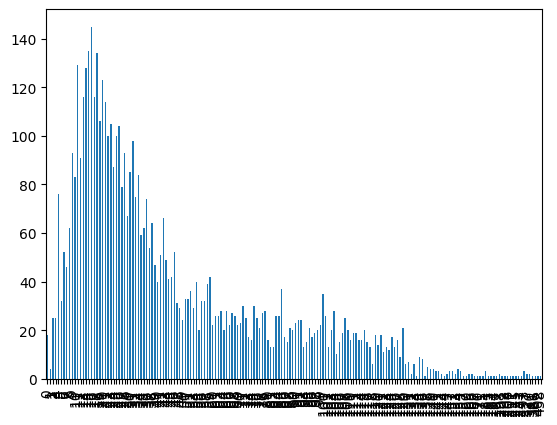

In [21]:
df['len_review'].value_counts().sort_index().plot(kind='bar')

In [22]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) 
tokenizer.fit_on_texts(df["review_clean"])
df["review_encoded"] = tokenizer.texts_to_sequences(df["review_clean"])

In [23]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df["review_encoded"], padding="post")

xtrain, xval, ytrain, yval = train_test_split(reviews_pad,df["target"], test_size=0.3)

train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [24]:
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[ 53 819  15 ...   0   0   0]
 [173   0   0 ...   0   0   0]
 [145 458 296 ...   0   0   0]
 ...
 [ 24 132  51 ...   0   0   0]
 [113 897   0 ...   0   0   0]
 [455 938  70 ...   0   0   0]], shape=(64, 54), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(64,), dtype=int32)


In [25]:
vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([             
            tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),  
            tf.keras.layers.GlobalAveragePooling1D(),    
            tf.keras.layers.Dense(16, activation='relu'),      
            tf.keras.layers.Dense(1, activation="sigmoid")
                ])

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 8)             65528     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65,689
Trainable params: 65,689
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch)

Epoch 1/20
61/61 [==============================] - 1s 3ms/step - loss: 0.6078 - accuracy: 0.8551 - val_loss: 0.5188 - val_accuracy: 0.8600
Epoch 2/20
61/61 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.8685 - val_loss: 0.3877 - val_accuracy: 0.8600
Epoch 3/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.8685 - val_loss: 0.3640 - val_accuracy: 0.8600
Epoch 4/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.8685 - val_loss: 0.3514 - val_accuracy: 0.8600
Epoch 5/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3314 - accuracy: 0.8685 - val_loss: 0.3355 - val_accuracy: 0.8600
Epoch 6/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3137 - accuracy: 0.8685 - val_loss: 0.3139 - val_accuracy: 0.8600
Epoch 7/20
61/61 [==============================] - 0s 2ms/step - loss: 0.2882 - accuracy: 0.8685 - val_loss: 0.2831 - val_accuracy: 0.8600
Epoch 8/20
61/61 [==

In [29]:
model_loss = pd.DataFrame(model.history.history)
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.607775,0.855128,0.518788,0.860048
1,0.435483,0.868462,0.387689,0.860048
2,0.360277,0.868462,0.363979,0.860048
3,0.344923,0.868462,0.351435,0.860048
4,0.331378,0.868462,0.335483,0.860048
5,0.313677,0.868462,0.313913,0.860048
6,0.288176,0.868462,0.283104,0.860048
7,0.256422,0.874872,0.247971,0.875598
8,0.222173,0.897949,0.214013,0.903708
9,0.189767,0.919744,0.182186,0.931818


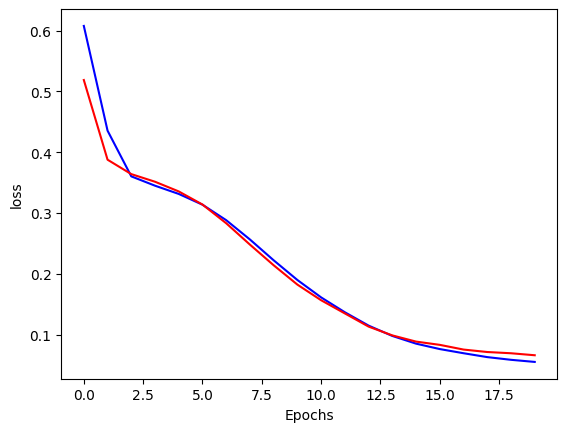

In [30]:
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

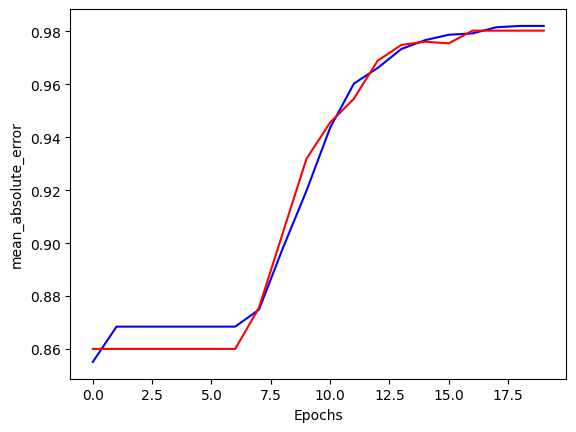

In [31]:
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()

In [34]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [35]:
label = LabelEncoder()
df['target'] = label.fit_transform(df['v1'])

In [36]:
xtrain, xval, ytrain, yval = train_test_split(df["v2"],df["target"], test_size=0.3)

train_data = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((xval, yval))

In [37]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)


In [38]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=val_data.batch(512),
                    verbose=1)

Epoch 1/20
8/8 [==============================] - 4s 434ms/step - loss: 0.6710 - accuracy: 0.8672 - val_loss: 0.6325 - val_accuracy: 0.8642
Epoch 2/20
8/8 [==============================] - 3s 419ms/step - loss: 0.5946 - accuracy: 0.8672 - val_loss: 0.5624 - val_accuracy: 0.8642
Epoch 3/20
8/8 [==============================] - 3s 423ms/step - loss: 0.5202 - accuracy: 0.8672 - val_loss: 0.4947 - val_accuracy: 0.8654
Epoch 4/20
8/8 [==============================] - 3s 434ms/step - loss: 0.4500 - accuracy: 0.8685 - val_loss: 0.4306 - val_accuracy: 0.8684
Epoch 5/20
8/8 [==============================] - 3s 418ms/step - loss: 0.3835 - accuracy: 0.8749 - val_loss: 0.3726 - val_accuracy: 0.8732
Epoch 6/20
8/8 [==============================] - 3s 414ms/step - loss: 0.3238 - accuracy: 0.8869 - val_loss: 0.3214 - val_accuracy: 0.8834
Epoch 7/20
8/8 [==============================] - 3s 416ms/step - loss: 0.2704 - accuracy: 0.9028 - val_loss: 0.2765 - val_accuracy: 0.8917
Epoch 8/20
8/8 [====

In [43]:
model_loss = pd.DataFrame(model.history.history)
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.671020,0.867180,0.632506,0.864234
1,0.594615,0.867180,0.562441,0.864234
2,0.520216,0.867180,0.494726,0.865431
3,0.449982,0.868462,0.430632,0.868421
4,0.383484,0.874872,0.372591,0.873206
5,0.323816,0.886923,0.321363,0.883373
6,0.270442,0.902821,0.276534,0.891746
7,0.223398,0.922051,0.237377,0.916268
8,0.182949,0.942820,0.204556,0.932416
9,0.149177,0.962564,0.177957,0.948565


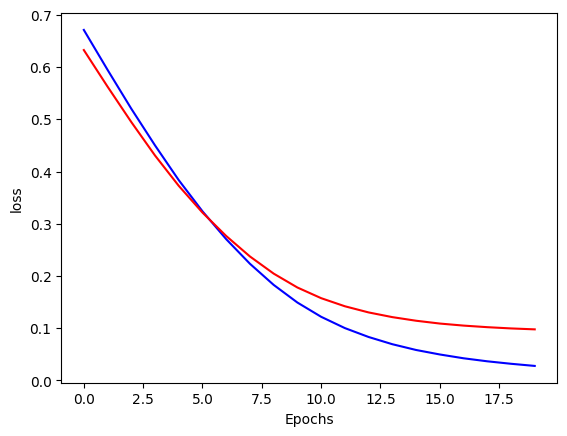

In [44]:
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

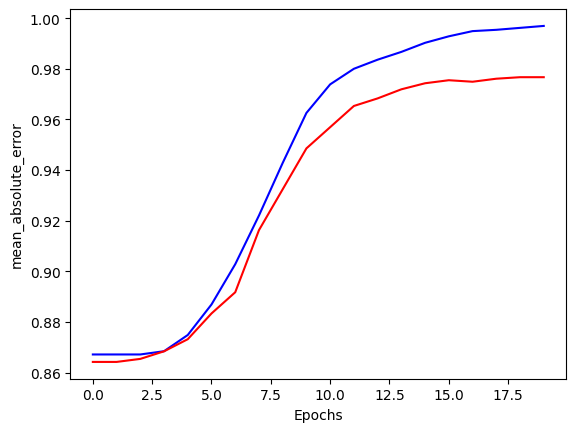

In [45]:
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()